<a href="https://colab.research.google.com/github/Tiru28/ModernAIPro/blob/main/Advanced_RAG_Techniques_Modern_AI_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modern AI Pro: Advanced RAG with LLMs
The reasons why we need to use RAG:
Problems that RAGs try to solve in LLMs

1. Hallucination — wrong generation with high confidence
2. Attribution — where does the information come from
3. Staleness — cut off date
4. Revisions — remove or revise information in the corpus
5. Customization — make it work in your own state
6. Low setup cost

## Step 1: Load the data
Building on top of this earlier [class](https://colab.research.google.com/drive/1BatABgfZpBdj1gIj6YVAs4ZuSOi2P9tr#scrollTo=Ejlt8qDLfoYV).

In [ ]:
!pip install -U -q langchain_groq pypdf2 langchain langchain-community sentence-transformers chromadb umap-learn tqdm
from langchain_groq import ChatGroq
from google.colab import userdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 39.9 MB/s eta

In [ ]:
llm_groq = ChatGroq(model_name="llama-3.3-70b-versatile", api_key=userdata.get("GROQ_API_KEY"))

In [ ]:
import urllib.request
import PyPDF2
import io

franklin_10k = 'https://s201.q4cdn.com/562074409/files/doc_financials/2023/ar/Franklin-Resources-2023-Annual_10-K.pdf'
req = urllib.request.Request(franklin_10k, headers={'User-Agent' : "Magic Browser"})
remote_file = urllib.request.urlopen(req).read()
remote_file_bytes = io.BytesIO(remote_file)
reader = PyPDF2.PdfReader(remote_file_bytes)
pdf_texts = [p.extract_text().strip() for p in reader.pages]
pdf_texts = [text for text in pdf_texts if text]

In [ ]:
# Utils:
def word_wrap(string, n_chars=128):
    # Wrap a string at the next space after n_chars
    if len(string) < n_chars:
        return string
    else:
        return string[:n_chars].rsplit(' ', 1)[0] + '\n' + word_wrap(string[len(string[:n_chars].rsplit(' ', 1)[0])+1:], n_chars)

word_wrap(pdf_texts[1])

'f FRANKLIN RESOURCES, INC. ANNU AL REPORT 2023\nImportant Information Regarding Forward-Looking Statements and Non-GAAP\nFinancial Information\nThis report contains forward-looking statements that are provided under the “safe harbor” protection of\nthe Private Securities Litigation Reform Act of 1995  \nand involve a number of known and unknown risks, uncertainties and other\nimportant factors. You should read the discussions under the headings “Forward- \nLooking Statements” and “Risk Factors” in Part\nI of our Annual Report on Form 10-K for our fiscal year ended September 30, 2023 (“Form 10-K”) for important \ninformation\nconcerning such matters. This report also contains non-GAAP financial measures such as adjusted operating revenues, adjusted\noperating income, \nadjusted operating margin, adjusted net income and adjusted diluted earnings per share, which are not\nsubstitutes for measures calculated in accordance with \nU.S. GAAP. You should read the “Supplemental Non-GAAP Financ

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=20
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(word_wrap(character_split_texts[10]))
print(f"\nTotal chunks: {len(character_split_texts)}")

Firms with a broader suite of investment 
capabilities that offer value beyond investing 
will be partners of choice. As
expectations 
increase for value-added services, we believe 
we are well-positioned in the long term  
due to the breadth and
depth of our 
investment capabilities, technology,  
content and capital resources.
One of our strategic priorities has been to

increase our scale in key segments of the 
industry that reflect client demand, including 
the insurance and retirement
sectors. We 
believe our differentiated model of preserving 
the investment autonomy of our specialist 
investment managers,
supported by the 
resources of a global firm, is unrivaled in the 
industry and should produce strong positive 
long-term
results.DO NOT
USE

Total chunks: 517


In [ ]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[0]))
print(f"\nTotal chunks: {len(token_split_texts)}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

one franklin parkway, san mateo, ca 94403 - 1906 franklinresources. comus _ cor _ 1826458 _ 1726458 fri a23 12 / 23 our
investment teams franklin templeton brings together a wide range of investment brands and teams to provide our clients deep
expertise within and across asset classes, investment styles and geographies. our unique business model combines the benefits
of global strength with the specialization of autonomous investment teams each with differentiated investment philosophies.
benefit street partners brandywine global clarion partners clearbridge investments fiduciary trust international franklin
equity group franklin income investors franklin mutual series franklin templeton fixed income franklin templeton global private
equity franklin templeton investment solutionsk2 advisors lexington partners martin currie o ’ shaughnessy asset management
royc e investment partners templeton global investments templeton global macro western asset

Total chunks: 636


In [ ]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[array([ 3.89491841e-02, -2.09602132e-03, -3.32668908e-02, -2.66484972e-02,
       -4.06250469e-02,  4.73800972e-02,  9.45648253e-02,  3.22575048e-02,
        1.75265167e-02, -1.10905254e-02,  3.07309115e-03,  9.89290476e-02,
        7.12690130e-02,  6.26527816e-02,  3.07268016e-02, -6.19025081e-02,
        6.55722618e-03, -3.30716483e-02, -6.91752210e-02,  3.31605747e-02,
       -8.15860555e-02, -8.95177424e-02, -5.03035821e-02,  2.17429269e-02,
        3.39858830e-02, -1.00595132e-01,  5.96533865e-02,  3.78270820e-02,
       -3.80799472e-02, -2.20583659e-02, -2.16073496e-03,  4.70764935e-02,
        1.51314428e-02, -1.57339498e-02, -1.69190280e-02,  7.18694478e-02,
       -1.00776277e-01, -4.51622866e-02,  1.79220904e-02,  1.17180562e-02,
        1.90538261e-02, -3.02120186e-02, -3.15918326e-02,  1.72552411e-02,
        4.22876468e-03, -7.66652822e-02, -2.62455270e-02, -2.02871356e-02,
        1.82627123e-02,  3.90992649e-02, -8.34820792e-02, -6.79827183e-02,
       -9.00641158e-02, 

In [ ]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("ft_annual_report", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

636

## Step 2: Visualize the query.

In [ ]:
import umap
from tqdm import tqdm #Progress bar for python
import numpy as np
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [ ]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
  0%|          | 0/636 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/636 [00:02<27:10,  2.57s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(query, projected_query_embedding, projected_retrieved_embeddings):
  plt.figure()
  plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
  plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
  plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

  plt.gca().set_aspect('equal', 'datalim')
  plt.title(f'{query}')
  plt.axis('off')


In [ ]:
def analyze_query(query):
  results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])
  retrieved_documents = results['documents'][0]

  for document in results['documents'][0]:
    print(word_wrap(document),"\n")

  projected_retrieved_embeddings = project_embeddings(results['embeddings'][0], umap_transform)
  query_embedding = embedding_function([query])[0]

  projected_query_embedding = project_embeddings([query_embedding], umap_transform)

  visualize_results(query, projected_query_embedding, projected_retrieved_embeddings)


continued contributions of these people. global and / or local laws and regulations could impose restrictions on compensation
paid by financial institutions, which could restrict our ability to compete effectively for qualified professionals. as our
business develops, we may need to increase the number of individuals that we employ. moreover, in order to retain certain key
personnel, we may be required to increase compensation to such individuals and increase our key management succession planning,
resulting in additional expense without a corresponding increase in potential revenues. there is no assurance that we will be
successful in finding, attracting and retaining qualified individuals, and the departure of key investment personnel, in
particular, could cause us to lose clients, which could have a material adverse effect on our financial condition, results of
operations and business prospects. in addition, due to the global nature of our business, our 

subsidiaries are determined

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  war

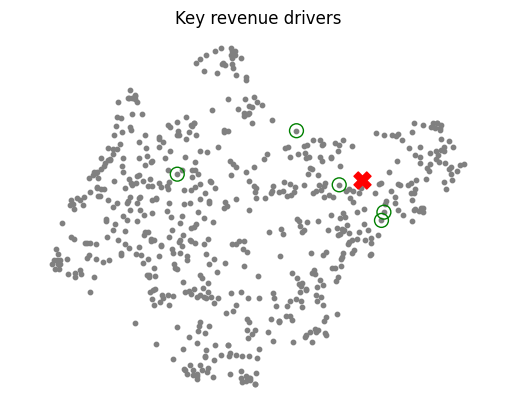

In [ ]:
#Trying a general query
query = "Key revenue drivers"
analyze_query(query)

## Step 3: Augment the query

In [ ]:
def rag_query(query):
  results = chroma_collection.query(query_texts=[query], n_results=5)
  retrieved_documents = results['documents'][0]
  information = "\n\n".join(retrieved_documents)
  return llm_groq.invoke(f"Question: {query}. \n Information: {information}")

rag_query(query)

AIMessage(content="The key revenue drivers for this company are:\n\n1. **Assets Under Management (AUM) growth**: The company's revenue is directly tied to the growth of its AUM, as management fees are earned based on the level of assets managed.\n2. **Investment performance**: Strong investment performance is critical to stimulating sales of the company's products and maintaining a high level of AUM, which in turn drives revenue growth.\n3. **Client retention and acquisition**: The company's ability to retain existing clients and attract new ones is crucial to maintaining and growing its revenue base.\n4. **Competitive compensation packages**: The company's ability to offer competitive compensation packages to its key personnel, including portfolio managers, investment analysts, and sales teams, is essential to attracting and retaining top talent, which in turn drives revenue growth.\n5. **Distribution and client service**: The company's ability to achieve superior distribution and cli

In [ ]:
def augment_query_generated(query):
  augmented_query = f"Provide an example answer to the given question, that might be found in a document like an annual report. The question is: {query}"
  #print(augmented_query)
  return llm_groq.invoke(augmented_query).content

augmented_query = augment_query_generated(query)

In [ ]:
join_query = f"{query}{augmented_query}"
print(word_wrap(join_query))

Key revenue driversOur key revenue drivers for the fiscal year were:

1. **Expansion of Core Product Offerings**: We
experienced significant growth in sales of our flagship products, driven by increased demand from existing customers and the
acquisition of new clients. This was largely attributed to the launch of new features and enhancements, which improved the
overall value proposition and competitiveness of our products in the market.

2. **Geographic Expansion**: Our strategic
efforts to enter new markets and expand our presence in existing ones yielded substantial revenue gains. We established a
strong foothold in the Asia-Pacific region, which contributed notably to our top-line growth.

3. **Strategic Partnerships and
Collaborations**: Collaborations with key industry players enabled us to tap into new revenue streams and broaden our customer
base. These partnerships not only enhanced our product offerings but also facilitated access to previously untapped markets,
contributing 

In [ ]:
def augmented_rag(query):
  aug_query = augment_query_generated(query)
  join_query = f"{query}{augmented_query}"
  return rag_query(join_query).content

In [ ]:
print(augmented_rag(join_query))

The provided text appears to be a portion of an annual report or a similar document from a financial services company, likely an asset management firm. The key points discussed include:

1. **Key Revenue Drivers**: The company identifies five key drivers of revenue growth:
   - Expansion of core product offerings
   - Geographic expansion
   - Strategic partnerships and collaborations
   - Digital transformation initiatives
   - Data-driven decision making

2. **Technology and Security Risks**: The company acknowledges that its ability to manage and grow the business can be impeded by technological limitations and the need to adapt to new technologies, regulatory requirements, and client demands.

3. **Industry Trends and Pressures**: The asset management industry is facing disruption due to trends such as:
   - Advances in technology and digital wealth tools
   - Increasing client interest in digital interaction with investment portfolios
   - Growing crypto asset markets with regulat

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' w

(np.float64(-0.3849144700914622),
 np.float64(10.033666704967619),
 np.float64(4.074759864807129),
 np.float64(12.585669136047363))

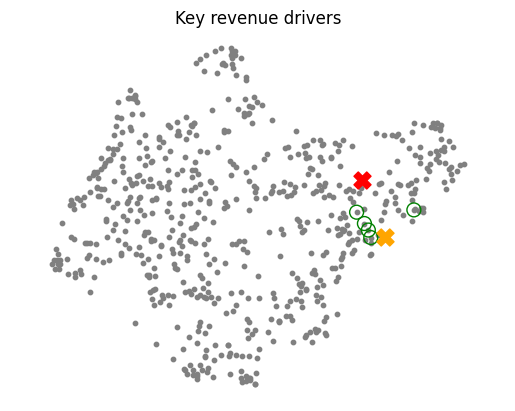

In [ ]:
results = chroma_collection.query(query_texts=join_query, n_results=5, include=['documents', 'embeddings'])
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([query])
augmented_query_embedding = embedding_function([join_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

## Step 4: Using cross encode models for ranking


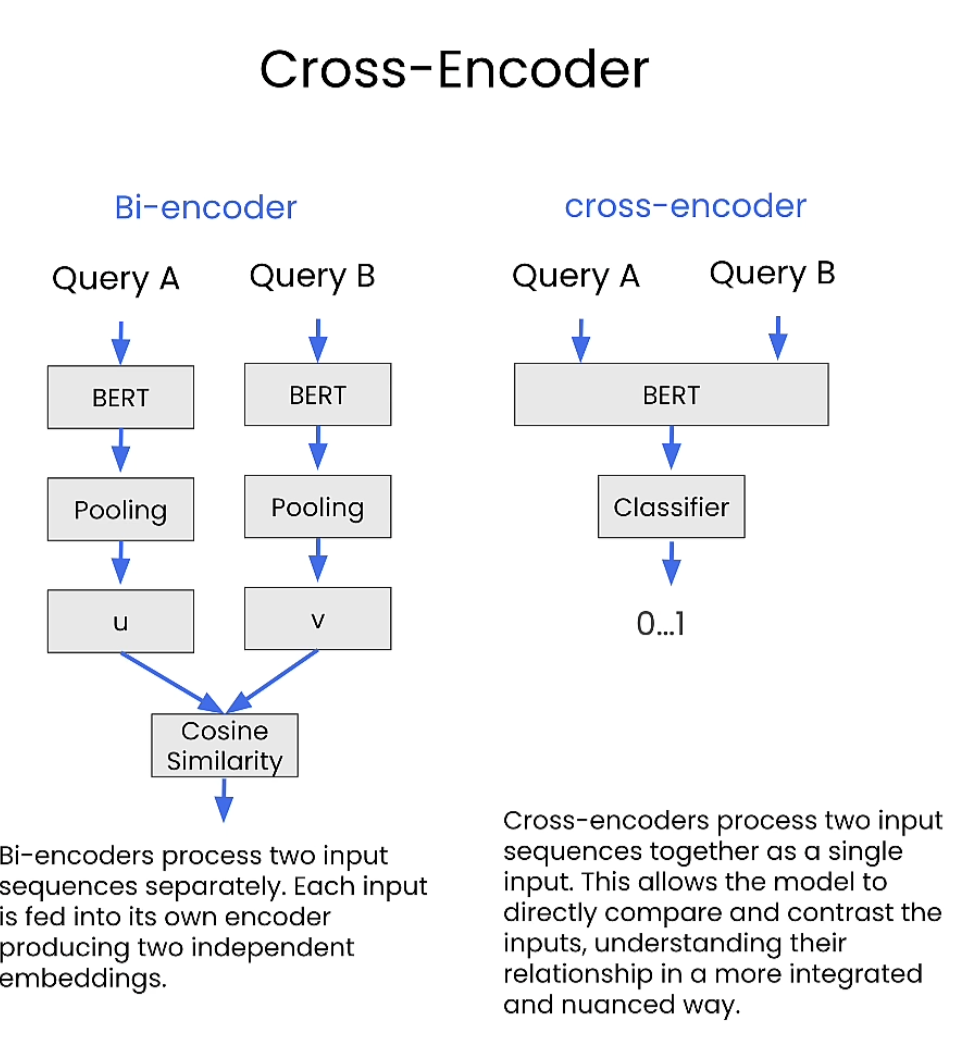

In [ ]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

In [ ]:
def compute_ranking(query):
  results = chroma_collection.query(query_texts=[query], n_results=20)
  retrieved_documents = results['documents'][0]
  pairs = [[query, doc] for doc in retrieved_documents]
  scores = cross_encoder.predict(pairs)

  sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]

  print("Scores and New Ordering:")
  for rank, index in enumerate(sorted_indices, start=1):
      print(f"Score: {scores[index]}, New Order: {rank}")

  top_documents = [retrieved_documents[i] for i in sorted_indices]
  top_documents_joined = " ".join(top_documents)
  print("Combined Top 5 Documents:", top_documents_joined)

  return top_documents_joined


query = f"Who are the key executives of Franklin Templeton?"
top_docs = compute_ranking(query)
print(word_wrap(top_docs))

Scores and New Ordering:
Score: 5.666339874267578, New Order: 1
Score: 5.223697662353516, New Order: 2
Score: 4.708073616027832, New Order: 3
Score: 4.6262407302856445, New Order: 4
Score: 3.9229490756988525, New Order: 5
Combined Top 5 Documents: templeton ’ s financial flexibility and promote matthew nicholls executive vice president chief financial officer chief operating officerdiversification and discipline benefit shareholders and clients our continuing investments in the business, while protecting our financial position in the context of challenging market conditions. great - west lifeco will make an initial incremental long - term asset allocation of $ 25 billion to our specialist investment manager s and become a long - term shareholder in franklin resources. the agreement furthers our goal of growing insur ance client assets and expands the existing relationship between franklin templeton and the power group of companies in the key areas of retirement, asset management and we

In [ ]:
new_query = f"Answer this specific Question: {query} from the source documents: {top_docs}"
print(llm_groq.invoke(new_query).content)

The key executives of Franklin Templeton mentioned in the source document are:

1. Jennifer M. Johnson - President and Chief Executive Officer, Franklin Resources, Inc.
2. Matthew Nicholls - Executive Vice President, Chief Financial Officer, and Chief Operating Officer
3. Alok Sethi - Executive Vice President and Head of Global Operations
4. Gwen L. Shaneyfelt - Chief Accounting Officer
5. Adam B. Spector - Executive Vice President and Head of Global Distribution

Additionally, other executives mentioned in the document include:

1. Selene Oh - Chief Communications Officer
2. Jennifer Ball - Chief Marketing Officer
3. Adam Petryk, CFA - Head of Franklin Templeton Investment Solutions
4. Brett Goldstein, CFA - Co-Chief Investment Officer, Putnam Global Asset Allocation
5. Wylie Tollette, CFA - Chief Investment Officer, Franklin Templeton Investment Solutions
6. Robert Schoen - Co-Chief Investment Officer, Putnam Global Asset Allocation


In [ ]:
print(augmented_rag(query))

The key executives of Franklin Templeton mentioned are:

1. **Jenny Johnson** (not mentioned in the provided text, but she is the President and CEO of Franklin Templeton)
2. **Selene Oh** - Chief Communications Officer
3. **Jennifer Ball** - Chief Marketing Officer
4. **Adam Petryk, CFA** - Head of Franklin Templeton Investment Solutions
5. **Brett Goldstein, CFA** - Co-Chief Investment Officer, Putnam Global Asset Allocation
6. **Wylie Tollette, CFA** - Chief Investment Officer, Franklin Templeton Investment Solutions
7. **Robert Schoen** - Co-Chief Investment Officer, Putnam Global Asset Allocation

Note: The text does not provide a comprehensive list of key executives, but these individuals are mentioned as part of the company's leadership team. Jenny Johnson is the President and CEO of Franklin Templeton, but she is not mentioned in the provided text.


In [ ]:
print(rag_query(query).content)

The key executives of Franklin Templeton mentioned in the text are:

1. Jennifer M. Johnson - President and Chief Executive Officer, Franklin Resources, Inc.
2. Matthew Nicholls - Executive Vice President, Chief Financial Officer, and Chief Operating Officer
3. Selene Oh - Chief Communications Officer
4. Jennifer Ball - Chief Marketing Officer
5. Adam Petryk, CFA - Head of Franklin Templeton Investment Solutions
6. Brett Goldstein, CFA - Co-Chief Investment Officer, Putnam Global Asset Allocation
7. Wylie Tollette, CFA - Chief Investment Officer, Franklin Templeton Investment Solutions
8. Robert Schoen - Co-Chief Investment Officer, Putnam Global Asset Allocation

These executives play important roles in the management and operations of Franklin Templeton, including investment management, marketing, communications, and financial management.
